# Negative breaks XGBoost model - local run with loop

### Peter R.
#### 2024-03-07

NOte: Here I use h2p, that is Bfast breaks with h=0.0025 or ~ 2%. The filtering of records with h2p is different than with h5p.

Today (2024-03-04) I meet with MJF to discuss XGB model improvements. An important number of Bfast breaks have very wide confidence intervals (CIs) associated with the time of break. These CIs can range from about 1 month to 80+ months. These won't allow for high quality matching with yearly climate or disturbance data. For this reason, we decided to run XGB models with subsets of data, each subset has narrow CIs. We will run the following XGB models with the follwoing dataframe subsets:

- Dataframe3 (df3): Records with CIs shorter than 3 16-days data points (48 days or about 1.5 months)

- Dataframe6 (df6): Records with CIs shorter than 6 16-days data points (96 days or about 3 months)

- Dataframe9 (df9): Records with CIs shorter than 9 16-days data points (144 days or about 5 months)

- Dataframe23 (df23): Records with CIS shorter than 23 16-days data points (368 days or about 1 year)

Some questions to have in mind:

- How many matches with disturbance data do the above have?
- Why does forest age become the top ranking variable with VIFplust variable set?  This variable was number 10 in other previous XGB model.
- I am assuming that Hansen is best and that it only includes stand-replacing disturbances


In [11]:
# 2024-03-04
# Peter R.
# XGBoost script
# Positive breaks, n_estimators (number of trees)=1000 and with optimal parameter from DRAC model_bp1 & early stopping

#Here I am using a loop to run several models at a time

import os
import time

import pandas as pd
from numpy import nan
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# for feature importance plots
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np

#for dependency plots
from sklearn.inspection import PartialDependenceDisplay

#start = time.time()

# Get the current working directory
cwd = os.getcwd()

#print(cwd)

# DRAC directory
#os.chdir("/home/georod/projects/def-mfortin/georod/scripts/github/forc_trends/models/xgboost")
# Win directory
os.chdir(r'C:\Users\Peter R\github\forc_trends\models\xgboost')


print("XGB version:", xgb.__version__)
print("negative breaks")


# Windows
df1 = pd.read_csv(r'.\data\forest_evi_breaks_negative_h2p_v3.csv', skipinitialspace=True)
# DRAC
#df1 = pd.read_csv(r'./data/forest_evi_breaks_positive_v2.csv', skipinitialspace=True)
#df1.head()


df11 = pd.get_dummies(df1, columns=['for_pro'], dtype=float)

#Df0: all rows
#df2 = df11 # N=843
# Df3: 1.5 months, version4/df3
#df2 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.1315068) & (df11['magnitude'] < -700)] #N= 171
# Df6: 3 months, version4/df6
#df2 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.2630137) & (df11['magnitude'] < -700)] #N= 450
# Df9: 5 months, version4/df9
# df2 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 0.3945205) & (df11['magnitude']< -700)] #N=523
# Df23: 12 months, 1 year, version4/df23
df2 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 1.008219) & (df11['magnitude'] < -700)] #N=649

# Df23v2: 12 months, 1 year, bounded by same year, version4/df23v2
#df2 = df11.loc[(df11['brkdate95']-df11['brkdate25'] <= 1.008219) & (df11['magnitude'] < -700)] # N=2291
#df2 = df2.loc[(np.floor(df2['brkdate95'])==np.floor(df2['brkdate25']))]




XGB version: 1.7.6
negative breaks


In [12]:
#print(df2[['canlad_year']].describe())#
#print(df2[['hansen_year']].describe())#
print(df2.describe()) #Full data: 11969; df4=1360; df5=5861

                 pix         year    brk    brkdate25      brkdate  \
count     649.000000   649.000000  649.0   649.000000   649.000000   
mean   158581.280431  2012.032357    0.0  2012.295960  2012.471607   
std    160243.791689     5.544478    0.0     5.597036     5.604650   
min       660.000000  2003.000000    0.0  2003.304000  2003.435000   
25%     16143.000000  2007.000000    0.0  2006.913000  2007.000000   
50%     86220.000000  2013.000000    0.0  2013.043000  2013.304000   
75%    290455.000000  2017.000000    0.0  2017.391000  2017.652000   
max    490159.000000  2022.000000    0.0  2022.391000  2022.478000   

         brkdate95    magnitude  no_brk  fire_year    harv_year  ...  \
count   649.000000   649.000000     0.0       42.0   160.000000  ...   
mean   2012.571535 -1736.807975     NaN     2018.0  2011.606250  ...   
std       5.602075   717.102894     NaN        0.0     4.530951  ...   
min    2003.478000 -4472.944000     NaN     2018.0  2004.000000  ...   
25%    20

MSE: 500203.60
RMSE: 707.25
R-sq: -0.044
R-sq-adj: -0.123
| 500203.60 | 707.25 | -0.044 | -0.123 | 649 | 15 |
MSE: 503435.81
RMSE: 709.53
R-sq: -0.051
R-sq-adj: -0.087
| 503435.81 | 709.53 | -0.051 | -0.087 | 649 | 7 |
MSE: 511248.84
RMSE: 715.02
R-sq: -0.067
R-sq-adj: -0.114
| 511248.84 | 715.02 | -0.067 | -0.114 | 649 | 9 |


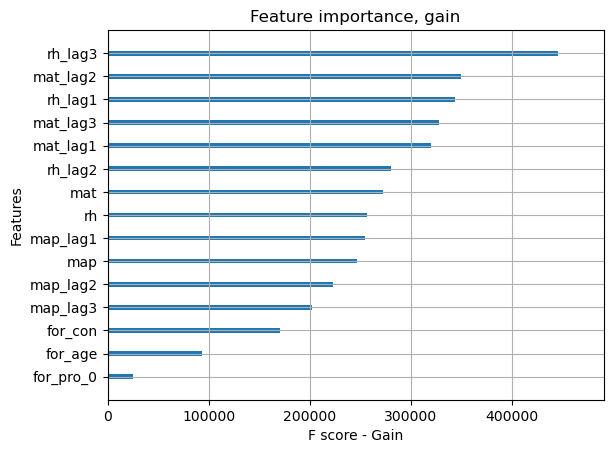

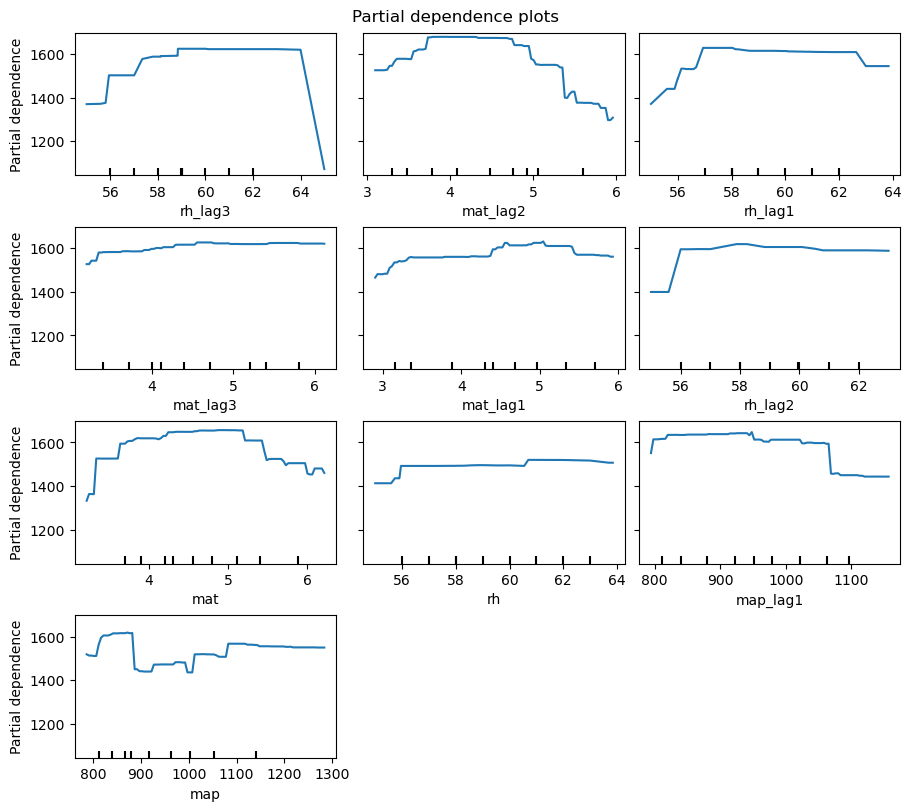

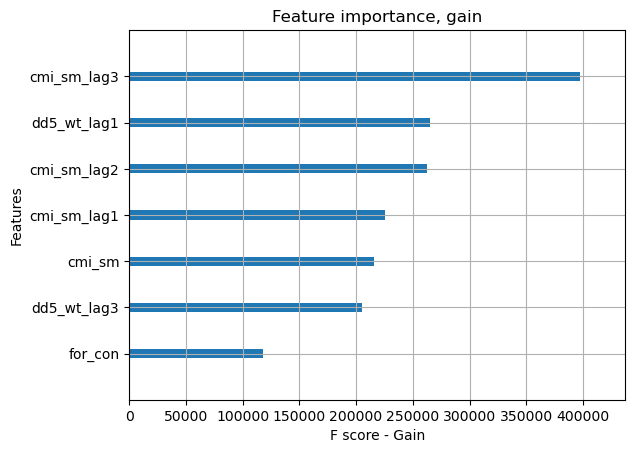

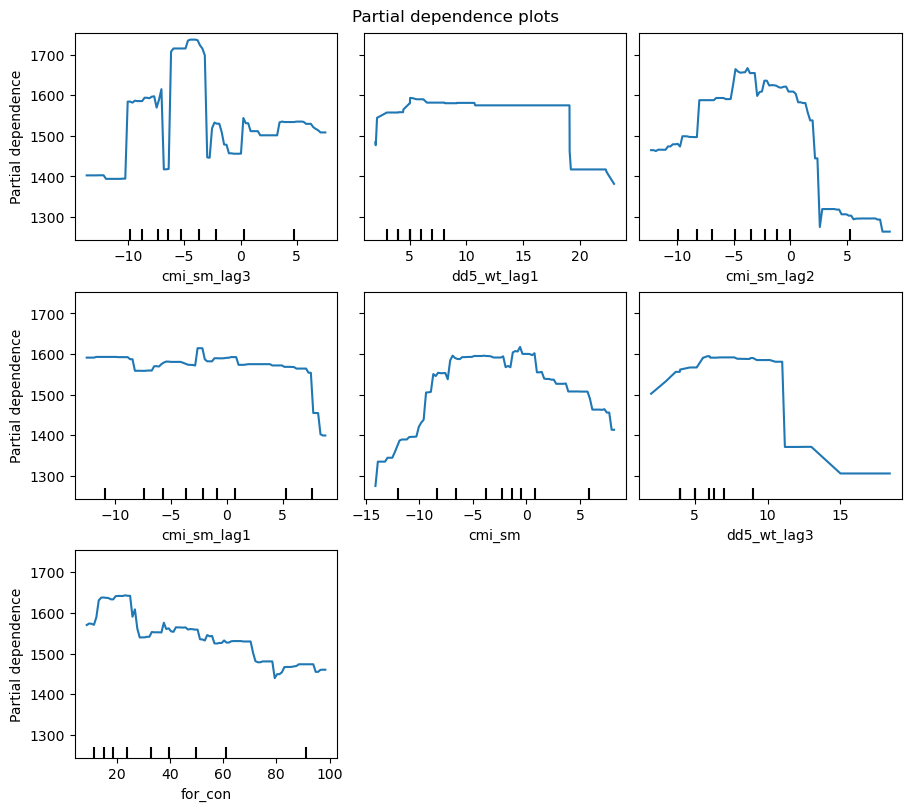

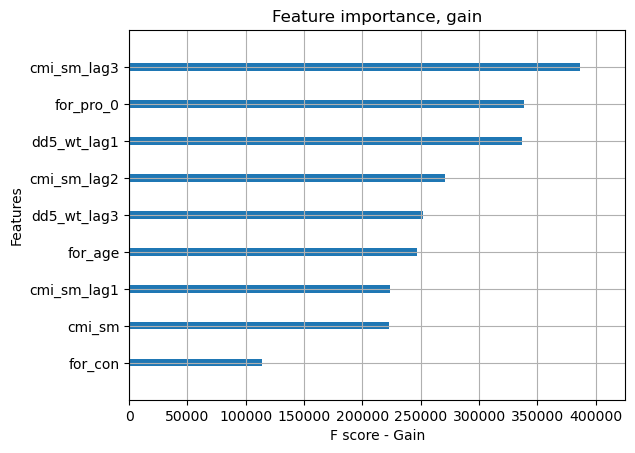

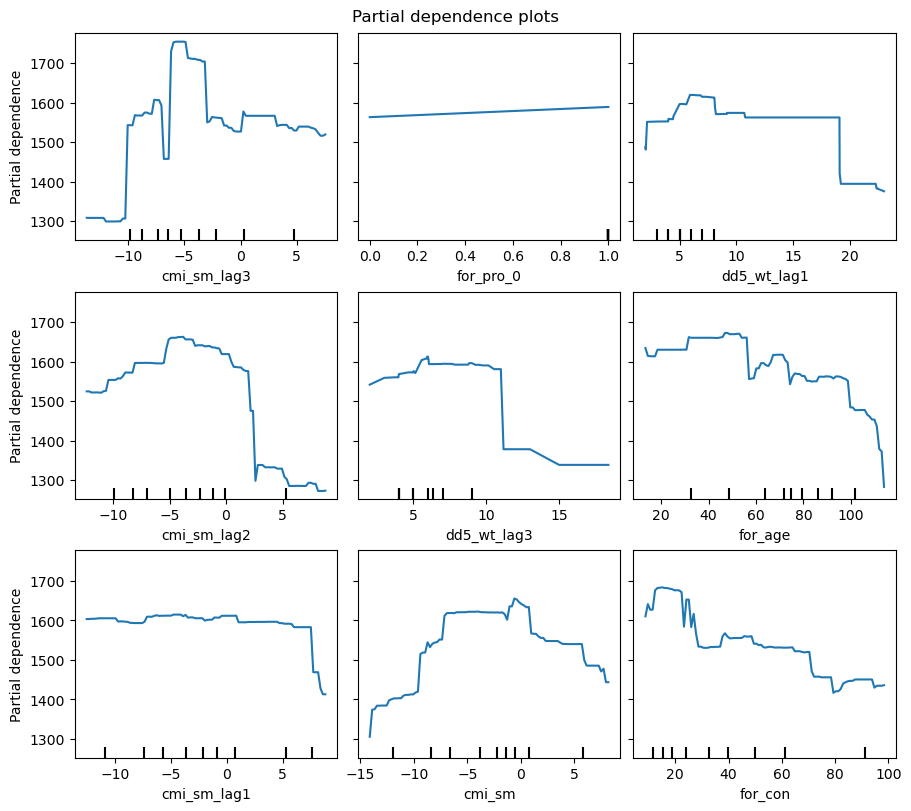

In [13]:
# loop version

cols1 = ['for_age', 'for_con', 'map', 'map_lag1', 'map_lag2', 'map_lag3', 'mat', 'mat_lag1', 'mat_lag2', 'mat_lag3', 'rh', 'rh_lag1', 'rh_lag2', 'rh_lag3', 'for_pro_0']
cols2 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3']
cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']

dfs=[0,3,6,9,23]

list_of_vars = [ [cols1], [cols2], [cols3]]
list_of_vars_labs = ['First variable set', 'VIF variable set', 'VIFplus variable set']
for list in list_of_vars:
    for x in list:
        #print(x)
        X1 = df2[x]
        #print(X1.describe())
        y1 = df2.iloc[:,6].abs()
        seed = 7 # random seed to help with replication
        testsize1 = 0.33 # percent of records to test after training
        x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
        model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
           # EVALUATION (with test)
        eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
            #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
        model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
            # make predictions for test data
        y_pred = model_bp2.predict(x1_test)
        predictions = [round(value) for value in y_pred]
            # retrieve performance metrics
        results = model_bp2.evals_result()
        mse = mean_squared_error(y1_test, y_pred)
            #r2 = explained_variance_score(y1_test, ypred)
        r2 = r2_score(y1_test, y_pred)
            # adjusted R-squared
        adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

        print("MSE: %.2f" % mse)
        var1 = "%.2f" % mse

        print("RMSE: %.2f" % (mse**(1/2.0)))
        var2 = "%.2f" % (mse**(1/2.0))

        print("R-sq: %.3f" % r2)
        var3 = "%.3f" % r2

        print("R-sq-adj: %.3f" % adj_r2)
        var4 = "%.3f" % adj_r2
        
        var5 = X1.shape[0]
        var6 = X1.shape[1]
        
        # row for table
        print("| %.2f" % mse, "| %.2f" % (mse**(1/2.0)), "| %.3f" % r2, "| %.3f" % adj_r2, "|", X1.shape[0], "|", X1.shape[1],"|")
        
        # Feature importance plot
        xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )
            
        pyplot.savefig(r'.\figs\version4\h2p\df23\neg_gain_m{y}_v1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
        #pyplot.show()
        # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
        features_names1 = pd.DataFrame()
        features_names1['columns'] = X1.columns
        features_names1['importances'] = model_bp2.feature_importances_
        features_names1.sort_values(by='importances',ascending=False,inplace=True)
        features_names2 = features_names1['columns'].tolist()[0:10]

        _, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

        display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

        _ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

        pyplot.savefig(r'.\figs\version4\h2p\df23\neg_partial_dep_m{y}_v1.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
        
       # pyplot.show()
        

**Table 1**: Model comparison for negative breaks. Standard data set with all records (including NAs for for_age and for_con).


|ID|Data frame| Model   | MSE| RMSE| R-sq | R-sq-adj |N rows| N vars|
| --------| --------| --------| --------| -------- | ------- |-------- | ------- |------- |
|1|df0|First variable set | 665769.06 | 815.95 | 0.092 | 0.040 | 843 | 15 |
|2|df0|VIF variable set | 675948.36 | 822.16 | 0.078 | 0.054 | 843 | 7 |
|3|df0|VIFplus variable set | 689214.61 | 830.19 | 0.060 | 0.029 | 843 | 9 |
|4|df3|First variable set | 632532.01 | 795.32 | -0.293 | -0.767 | 171 | 15 |
|5|df3|VIF variable set | 824892.46 | 908.24 | -0.687 | -0.928 | 171 | 7 |
|6|df3|VIFplus variable set | 797202.43 | 892.86 | -0.630 | -0.942 | 171 | 9 |
|7|df6|First variable set | 559530.63 | 748.02 | -0.124 | -0.250 | 450 | 15 |
|8|df6|VIF variable set | 531616.88 | 729.12 | -0.068 | -0.121 | 450 | 7 |
|9|df6|VIFplus variable set | 575385.00 | 758.54 | -0.155 | -0.230 | 450 | 9 |
|10|df9|First variable set | 477554.55 | 691.05 | -0.028 | -0.126 | 523 | 15 |
|11|df9|VIF variable set | 513868.40 | 716.85 | -0.106 | -0.153 | 523 | 7 |
|12|df9|VIFplus variable set| 524740.66 | 724.39 | -0.129 | -0.191 | 523 | 9 |
|13|df23|First variable set | 500203.60 | 707.25 | -0.044 | -0.123 | 649 | 15 |
|14|df23|VIF variable set| 503435.81 | 709.53 | -0.051 | -0.087 | 649 | 7 |
|15|df23|VIFplus variable set| 511248.84 | 715.02 | -0.067 | -0.114 | 649 | 9 |







ID|Data frame| Model   | MSE| RMSE| R-sq | R-sq-adj |N rows| N vars|
| --------| --------| --------| --------| -------- | ------- |-------- | ------- |------- |
|[x]|'df0'|list_of_vars_labs[x]|var1|{{var2}}|{{var3}}|{{var4}}|{{var5}}|{{var6}}

In [14]:
#Describe the data
#X1 = df2[x]
#print(X1.shape)

In [15]:
#print(len(cols1))

In [16]:
# Count NAs per columns to check that step above worked #mat 607 before, now 0
#X1.isna().sum()

In [17]:
#X1.describe()

### Models without records that have disturbance matches

When dealing with positive forest EVI breaks, I can't remove records matched to Hansen et al.'s disturbance data as there are no such matched records. This makes sense as positive breaks should not be matched to disturbances.

In [18]:
# How many records are matched to disturbance data?
print(df2[['hansen_year']].describe()) # N=2775
print(df2[['magnitude', 'fire_year', 'harv_year', 'canlad_year', 'hansen_year']].describe()) # Hansen=? with df4; Hansen=648 with df5

       hansen_year
count   400.000000
mean   2012.752500
std       5.476882
min    2004.000000
25%    2007.000000
50%    2013.000000
75%    2018.000000
max    2022.000000
         magnitude  fire_year    harv_year  canlad_year  hansen_year
count   649.000000       42.0   160.000000   230.000000   400.000000
mean  -1736.807975     2018.0  2011.606250  2009.400000  2012.752500
std     717.102894        0.0     4.530951     3.731841     5.476882
min   -4472.944000     2018.0  2004.000000  2003.000000  2004.000000
25%   -2226.100000     2018.0  2007.000000  2006.000000  2007.000000
50%   -1605.786000     2018.0  2012.000000  2009.000000  2013.000000
75%   -1146.986000     2018.0  2015.000000  2013.000000  2018.000000
max    -703.970000     2018.0  2020.000000  2015.000000  2022.000000


There are matches when using CanLaD

In [19]:
#print(df2[['canlad_year']].describe()) # 2483; 247
#print(df2[['harv_year']].describe()) # 1187; 204
#print(df2[['fire_year']].describe()) # 139; 107

In [20]:
# This produces an empty df as there are no records
#df3 = df2.drop(df2[df2.hansen_year > 0].index)
#X3.tail
#X3.shape
#df3.describe()
#df2.drop(df2[df2.hansen_year > 0].index, inplace=True) # gives a warning
#df2.shape

#df2 = df2.loc[df2['hansen_year'] > 0] # 2775

df2 = df2.loc[df2['hansen_year'].isnull()]

df2.shape

(249, 158)

In [21]:
#df2.drop(df2[df2.hansen_year > 0].index).describe()

MSE: 595872.31
RMSE: 771.93
R-sq: -0.218
R-sq-adj: -0.491
| 595872.31 | 771.93 | -0.218 | -0.491 | 249 | 15 |
MSE: 618846.84
RMSE: 786.67
R-sq: -0.265
R-sq-adj: -0.383
| 618846.84 | 786.67 | -0.265 | -0.383 | 249 | 7 |
MSE: 619601.14
RMSE: 787.15
R-sq: -0.267
R-sq-adj: -0.423
| 619601.14 | 787.15 | -0.267 | -0.423 | 249 | 9 |


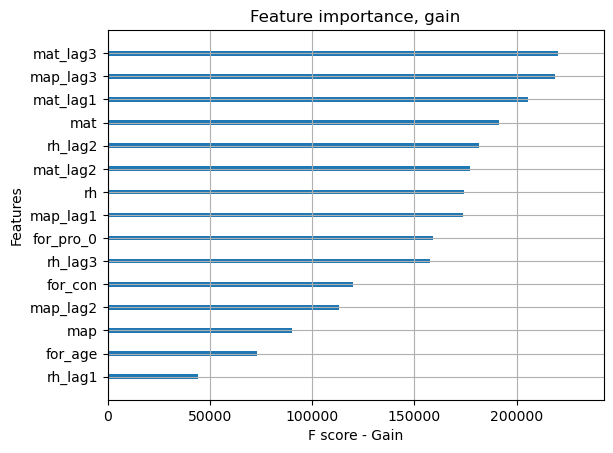

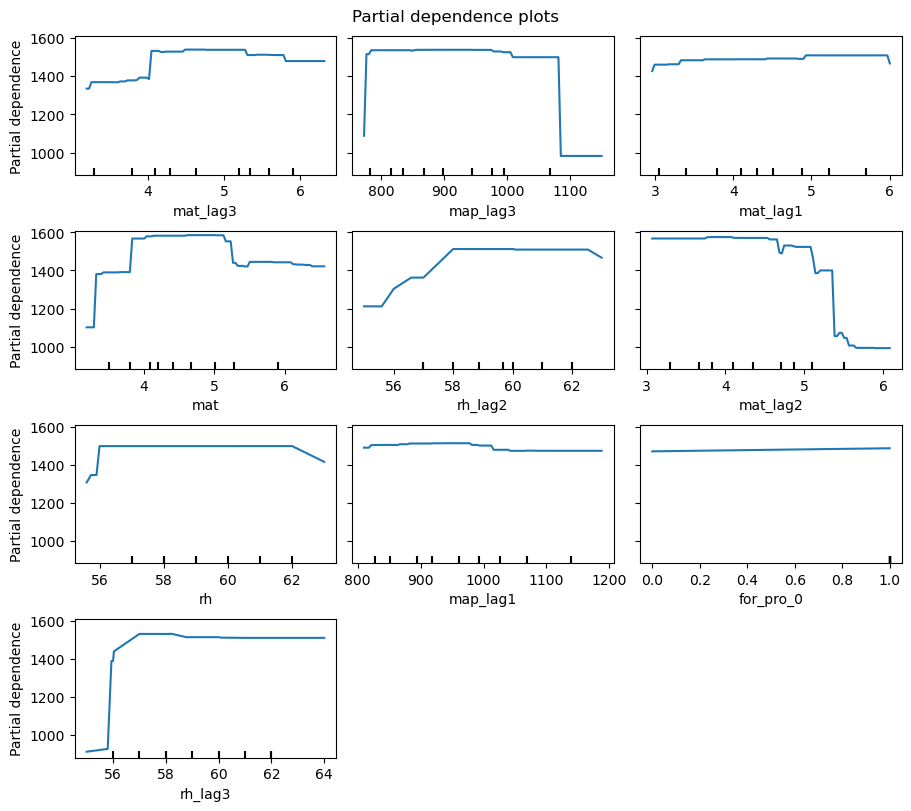

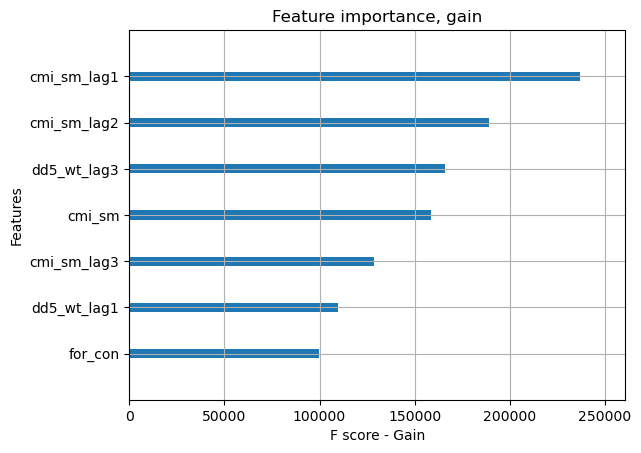

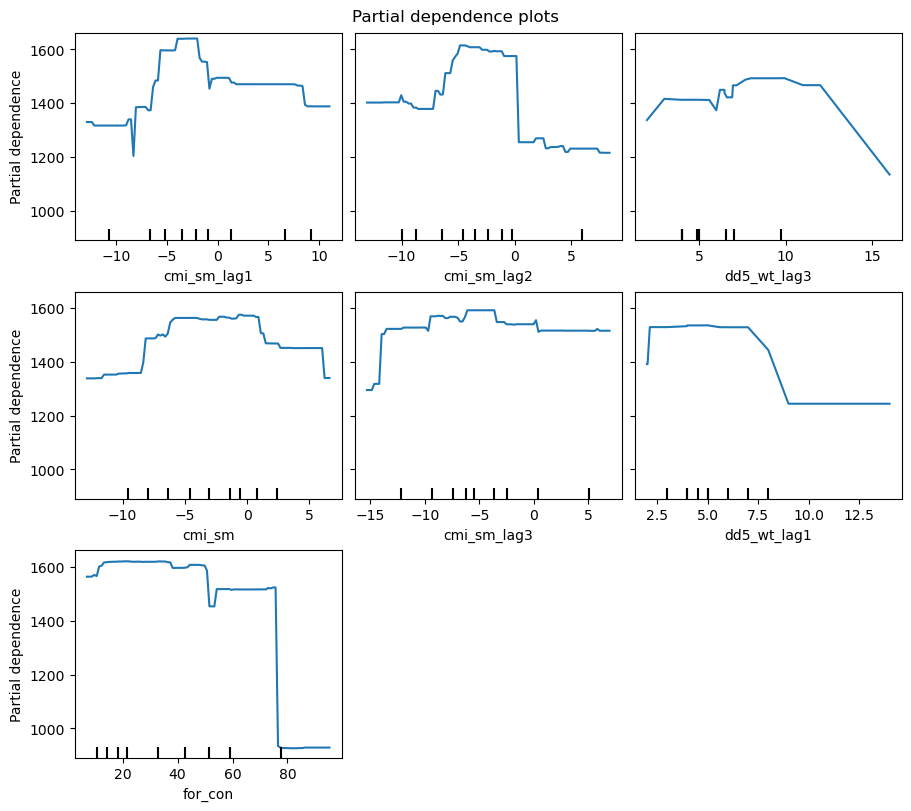

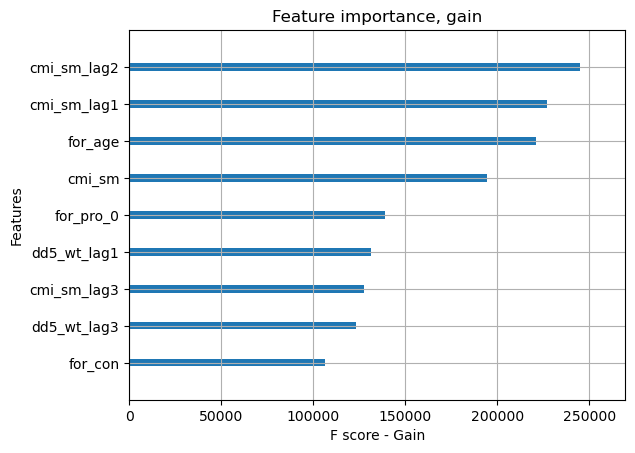

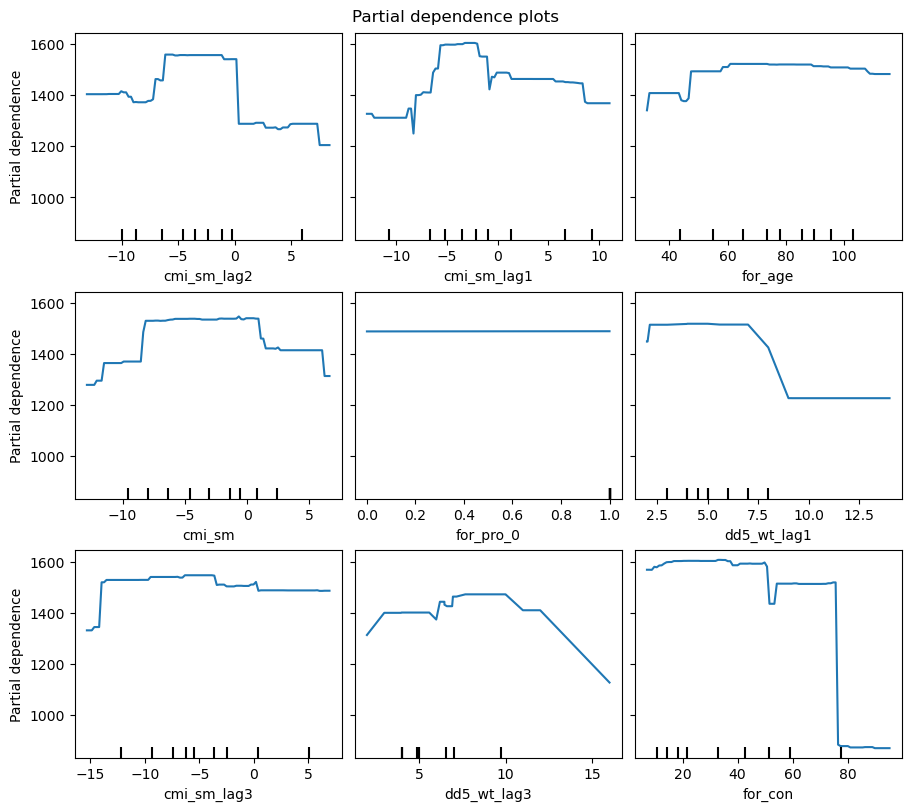

In [22]:
# loop version

cols1 = ['for_age', 'for_con', 'map', 'map_lag1', 'map_lag2', 'map_lag3', 'mat', 'mat_lag1', 'mat_lag2', 'mat_lag3', 'rh', 'rh_lag1', 'rh_lag2', 'rh_lag3', 'for_pro_0']
cols2 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3']
cols3 = ['for_con', 'cmi_sm', 'cmi_sm_lag1', 'cmi_sm_lag2', 'cmi_sm_lag3', 'dd5_wt_lag1', 'dd5_wt_lag3', 'for_age', 'for_pro_0']


list_of_vars = [ [cols1], [cols2], [cols3]]
for list in list_of_vars:
    for x in list:
        #print(x)
        X1 = df2[x]
        #print(X1.describe())
        y1 = df2.iloc[:,6].abs()
        seed = 7 # random seed to help with replication
        testsize1 = 0.33 # percent of records to test after training
        x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed) # Split data set. Note the 'stratify' option
        model_bp2 = XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, reg_lambda=10, reg_alpha=1)
           # EVALUATION (with test)
        eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
            #UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
        model_bp2.fit(x1_train, y1_train, eval_set=eval_set, verbose=False)
            # make predictions for test data
        y_pred = model_bp2.predict(x1_test)
        predictions = [round(value) for value in y_pred]
            # retrieve performance metrics
        results = model_bp2.evals_result()
        mse = mean_squared_error(y1_test, y_pred)
            #r2 = explained_variance_score(y1_test, ypred)
        r2 = r2_score(y1_test, y_pred)
            # adjusted R-squared
        adj_r2 = 1 - (((1-r2) * (len(y1_test)-1))/(len(y1_test)-x1_test.shape[1]-1))

        print("MSE: %.2f" % mse)

        print("RMSE: %.2f" % (mse**(1/2.0)))

        print("R-sq: %.3f" % r2)

        print("R-sq-adj: %.3f" % adj_r2)
        
         # row for table
        print("| %.2f" % mse, "| %.2f" % (mse**(1/2.0)), "| %.3f" % r2, "| %.3f" % adj_r2, "|", X1.shape[0], "|", X1.shape[1],"|")
        
        # Feature importance plot
        xgb.plot_importance(model_bp2, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance, gain', 
                    xlabel='F score - Gain', ylabel='Features', 
                    importance_type='gain', max_num_features=15, grid=True, show_values=False) #, values_format='{v:.2f}' )
            
        pyplot.savefig(r'.\figs\version4\h2p\df23\neg_gain_m{y}_v2.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
        #pyplot.show()
        # create lis of feature names to be used in dependency plot so that high ranking vars are plotted
        features_names1 = pd.DataFrame()
        features_names1['columns'] = X1.columns
        features_names1['importances'] = model_bp2.feature_importances_
        features_names1.sort_values(by='importances',ascending=False,inplace=True)
        features_names2 = features_names1['columns'].tolist()[0:10]

        _, ax1 = plt.subplots(figsize=(9, 8), constrained_layout=True)

        display = PartialDependenceDisplay.from_estimator(model_bp2, x1_train, features_names2, ax=ax1)

        _ = display.figure_.suptitle(("Partial dependence plots"), fontsize=12, )

        pyplot.savefig(r'.\figs\version4\h2p\df23\neg_partial_dep_m{y}_v2.png'.format(y=len(x)),  dpi=300, bbox_inches='tight')
        
        #pyplot.show()

Partial dependence plots

**Table 2**: Model comparison for negative breaks. Subset of data records was used, excluding records that had a match with disturbance data. (Some NAs for for_age and for_con.)

|ID| Data frame| Model   | MSE| RMSE| R-sq | R-sq-adj | N rows| N vars|
| --------| --------| -------- | ------- |-------- | ------- |------- |------- |------- |
|1|df0| First variable set | 592850.20 | 769.97 | -0.017 | -0.160 | 370 | 15 |
|2|df0| VIF variable set | 566875.66 | 752.91 | 0.028 | -0.032 | 370 | 7 |
|3|df0| VIFplus variable set | 579861.87 | 761.49 | 0.005 | -0.074 | 370 | 9 |
|4|df3| First variable set | 319156.02 | 564.94 | 0.373 | -1.508 | 63 | 15 |
|5|df3| VIF variable set | 659926.95 | 812.36 | -0.296 | -0.994 | 63 | 7 |
|6|df3| VIFplus variable set| 638790.01 | 799.24 | -0.255 | -1.281 | 63 | 9 |
|7|df6| First variable set |1005746.50 | 1002.87 | -0.458 | -0.991 | 170 | 15 |
|8|df6| VIF variable set | 948908.97 | 974.12 | -0.376 | -0.572 | 170 | 7 |
|9|df6| VIFplus variable set | 897955.17 | 947.60 | -0.302 | -0.551 | 170 | 9 |
|10|df9| First variable set | 678680.25 | 823.82 | -0.244 | -0.624 | 194 | 15 |
|11|df9| VIF variable set | 655274.58 | 809.49 | -0.201 | -0.348 | 194 | 7 |
|12|df9| VIFplus variable set | 715376.78 | 845.80 | -0.311 | -0.525 | 194 | 9 |
|13|df23| First variable set | 595872.31 | 771.93 | -0.218 | -0.491 | 249 | 15 |
|14|df23| VIF variable set | 618846.84 | 786.67 | -0.265 | -0.383 | 249 | 7 |
|15|df23| VIFplus variable set | 619601.14 | 787.15 | -0.267 | -0.423 | 249 | 9 |





In [23]:
# check one more
#df2.shape
X1.shape

(249, 9)